# Finding the Efficient Frontier of a Given Set of Securities

In [1]:
#Import Dependencies 
import requests, bs4, re, datetime, os, math, time
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import minimize
np.set_printoptions(precision=4)
np.set_printoptions(suppress=True)

# User Input
## Grab the User's preferences

In [2]:
#Regex to recognize dates
dateReg = re.compile(r'(\d\d?)/(\d\d?)/(\d\d\d\d)')
print('For default values, press enter without typing anything for all fields')
#Get User input for date
date = input('What date would you like to begin from? Please input in the form of dd/mm/yy\n')
if date == '':
    date = datetime.date(1980, 12, 31)
else:
    while dateReg.search(date) == None:
        date = input('Error: Please input in the form of dd/mm/yyyy\n')

#Repeat for the ending date
end = input('What date would you like to end at?\n')
if end == '':
    end = datetime.date.today()
else:
    while dateReg.search(end) == None:
        end = input('Error: Please input in the form of dd/mm/yyyy\n')

#Interval Preference
interval = input('What frequency?\nOptions:[1m, 2m, 5m, 15m, 30m, 60m, 90m, 1h, 1d, 5d, 1wk, 1mo, 3mo]\n')

if interval == '':
    interval = '1mo'
else:
    while interval not in ['1m', '2m', '5m', '15m', '30m', '60m', '90m', '1h', '1d', '5d', '1wk', '1mo', '3mo']:
        interval = input('Error:\nYou can only choose from [1m, 2m, 5m, 15m, 30m, 60m, 90m, 1h, 1d, 5d, 1wk, 1mo, 3mo]\n')
#Tickers
tickers = input('What tickers do you want to scrape?')
if tickers == '':
    tickers = ['KO', 'PFE', 'MRNA', 'T', 'GE', 'F', 'GLD', 'MGM', 'CZR', 'MSFT', 'NVDA', 'MCD']
else:
    tickers = re.compile(r'\w+').findall(tickers)
    
limit = input('What is your MAXIMUM risk tolerance? (The program will find optimal values for all levels of risk up to and including this value)\n')
if limit == '':
    limit = 25
else:
    while re.compile(r'\d+').search(limit) == None:
        limit = input('Error: Please input a number')
limit = int(limit)

For default values, press enter without typing anything for all fields
What date would you like to begin from? Please input in the form of dd/mm/yy
30/1/2000
What date would you like to end at?

What frequency?
Options:, 2m, 5m, 15m, 30m, 60m, 90m, 1h, 1d, 5d, 1wk, 1mo, 3mo]

What tickers do you want to scrape?KO T GE F MSFT GOOGL GLD MGM CZR MCD
What is your MAXIMUM risk tolerance? (The program will find optimal values for all levels of risk up to and including this value)
15


# Gather and Format data

In [3]:
def scrape(ticker, start, end, interval):
    global DataFrames

    #Convert to dates to Datetime Objects
    if start != datetime.date(1980, 12, 31):
        day = int(dateReg.search(start).group(1))
        month = int(dateReg.search(start).group(2))
        year = int(dateReg.search(start).group(3))

        date = datetime.date(year, month, day)
        
    else:
        date = start
        
    if end != datetime.date.today():
        day = int(dateReg.search(end).group(1))
        month = int(dateReg.search(end).group(2))
        year = int(dateReg.search(end).group(3))

        end = datetime.date(year, month, day)

    #Convert dates to Yahoo date-codes

    beginning = datetime.date(1969, 12, 31) #The earliest date offered by Yahoo (Period Zero)
    delta = date - beginning

    startCode = delta.days * 86637
    endCode = startCode + (end - date).days * 86637

    #Pull Data
    url = f'https://query1.finance.yahoo.com/v7/finance/download/{ticker}?period1={startCode}&period2={endCode}&interval={interval}&events=history&includeAdjustedClose=true'

    file = open('file.csv', 'w')
    res = requests.get(url)
    file.write(res.text)
    file.close()
    df = pd.read_csv('file.csv')
    os.remove('file.csv')

    lst = [0]
    i = 0
    before = df.iloc[0]['Adj Close']
    for row in df.iterrows():
        if i == 0: 
            i += 1
            continue
        change = 100 * ( (row[1]['Adj Close'] - before) / before )
        before = row[1]['Adj Close']
        lst.append(change)
    df['Adj Close'] = lst
    DataFrames.append(df)

In [4]:
#Execute the scrape function and compile into a master DataFrame

DataFrames = []

num = len(tickers)
for tick in tickers:
    scrape(tick, date, end, interval)

master = pd.DataFrame()

exes = []
wais = []
i = 0
for df in DataFrames:
    tick = tickers[i]
    frame = pd.DataFrame(df.set_index('Date')['Adj Close']).rename(columns= {'Adj Close': tick})
    master = master.merge(frame, left_index= True, right_index= True, how= 'outer')
    i += 1


# Portfolio Analysis
We have generated a master DataFrame with price-change data
We can do classic portfolio analysis now

In [5]:
#Generate covariance matrix
cov = master.cov()
cov

,KO,T,GE,F,MSFT,GOOGL,GLD,MGM,CZR,MCD
KO,24.474434,10.038726,11.535548,15.790368,9.658405,10.747726,3.131410,18.242512,30.373102,12.944605
T,10.038726,39.763842,16.405796,21.916611,12.080647,6.694328,-0.943762,16.739981,45.897781,12.138192
GE,11.535548,16.405796,74.205188,47.622841,22.045733,19.937603,-3.728800,83.371876,73.475176,10.927089
F,15.790368,21.916611,47.622841,193.267290,29.078740,26.202267,2.295991,178.959990,70.997349,16.457424
MSFT,9.658405,12.080647,22.045733,29.078740,66.977082,25.982009,-2.954392,38.840359,40.774722,9.591521
GOOGL,10.747726,6.694328,19.937603,26.202267,25.982009,79.327210,-1.773320,60.237907,44.609287,11.536894
GLD,3.131410,-0.943762,-3.728800,2.295991,-2.954392,-1.773320,24.622616,-2.226736,-10.158548,2.026585
MGM,18.242512,16.739981,83.371876,178.959990,38.840359,60.237907,-2.226736,452.213539,160.268003,21.663584
CZR,30.373102,45.897781,73.475176,70.997349,40.774722,44.609287,-10.158548,160.268003,341.266625,34.551792
MCD,12.944605,12.138192,10.927089,16.457424,9.591521,11.536894,2.026585,21.663584,34.551792,29.714589


Before maximizing returns, we'll find the lowest risk portfolio

In [6]:
#Variance objective function to minimize
def variance(x):
    x = x.reshape(-1, 1)
    new = np.matmul(np.matrix(cov), np.matrix(x))
    return math.sqrt(np.dot(x.reshape(-1), new))
   
        
x = np.array([1/num] * num).reshape(-1, 1)

In [7]:
#Define weight constraint
def weightCon(x):
    return 1 - np.sum(x)
constraint1 = {'type': 'eq', 'fun': weightCon}

#Define bounds
b = (0, 1)
bounds = [b] * num
val = minimize(variance, x, constraints=[constraint1],  method='SLSQP', bounds= bounds)

minVar = val.fun

# Maximizing Returns
We have our minimum amount of risk
Now we know our lower-limit risk tolerance
We can maximize returns for any given variance 

In [8]:
#New Objective Function
def exRet(x):
    return (np.dot(x.reshape(-1), master.mean())) * -1

#New Constraint
def varCon(x):
    x = x.reshape(-1, 1)
    new = np.matmul(np.matrix(cov), np.matrix(x))
    std = math.sqrt(np.dot(x.reshape(-1), new)) 
    return (std - limit) * -1

constraint2 = {'type': 'ineq', 'fun': varCon}

In [9]:
#Loop through all possible risk tolerances and find their optimal solution

exes = []
wais = []

for i in range(limit * 10):
    limit = limit - .1
    if limit < minVar:
        break
    val = minimize(exRet, x, constraints= [constraint1, constraint2], bounds= bounds, method= 'SLSQP')
    exes.append(limit)
    wais.append(val.fun * -1)
    
      

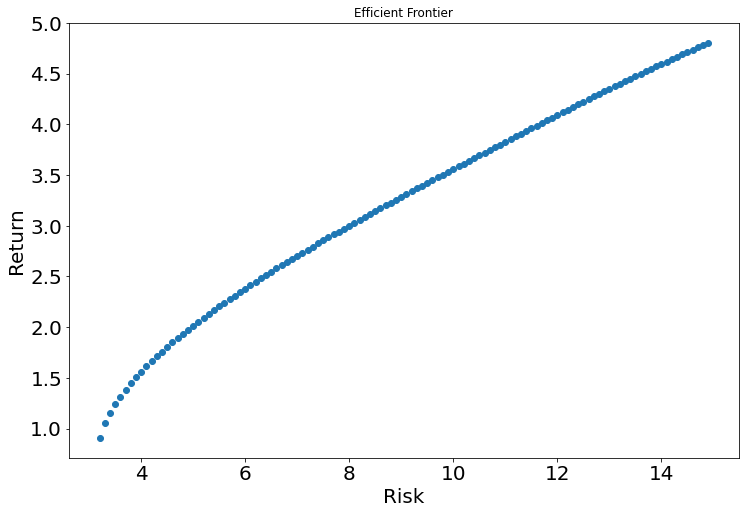

In [10]:
#Generate Plot
plt.figure(figsize=(12, 8))
plt.scatter(exes, wais)
plt.xlabel('Risk', fontsize = 20)
plt.ylabel('Return', fontsize = 20)

plt.tick_params(axis="x", labelsize=20)
plt.tick_params(axis="y", labelsize=20)

plt.title('Efficient Frontier')
plt.show()